In [1]:
if (!requireNamespace('BiocManager', quietly = TRUE)){
  install.packages('BiocManager')
}
if (!requireNamespace("Biobase", quietly = TRUE)) {
  install.packages("Biobase", dependencies = TRUE)
}
BiocManager::install('GEOquery')
install.packages("umap")
library(GEOquery)
library(limma)
library(umap)
library(Biobase)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.25), R 4.3.3 (2024-02-29)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'GEOquery'"
Old packages: 'RcppArmadillo', 'curl', 'dendextend', 'fontawesome', 'later',
  'progressr', 'promises', 'reticulate', 'uwot'




The downloaded binary packages are in
	/var/folders/2r/2m1p3nmd3m1235kf7dxs1cl40000gn/T//RtmpzhkkDU/downloaded_packages


Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)


Attaching package: 'limma'


The follow

# Differential Gene Expression Analysis

In [2]:
# load series and platform data from GEO

gset <- getGEO("GSE140829", GSEMatrix =TRUE, AnnotGPL=FALSE)

if (length(gset) > 1) idx <- grep("GPL15988", attr(gset, "names")) else idx <- 1

gset <- gset[[idx]]

# make proper column names to match toptable
fvarLabels(gset) <- make.names(fvarLabels(gset))

# group membership for all samples
gsms <- paste0("01010000010000002000000220001020100202200200000000",
         "11001000012202202100021202000000010220001222222112",
         "02002122101122101020000122102100112100120110001202",
         "11001000002000102210212020111022111220022102111202",
         "20120000200211220000112200000221000001222021002121",
         "22222210210020112022222022222202222220000220021021",
         "01020120210202021221000100111020022221022222122011",
         "12110121122220021112221220012101221221102210222122",
         "12222012001212222012022010000222201000220220210212",
         "00000200120000201000012202020202100120222001002101",
         "01010001001000000201021101001000102122221202010220",
         "2200002101010201020022110212120001021")
sml <- strsplit(gsms, split="")[[1]]

Found 1 file(s)

GSE140829_series_matrix.txt.gz



In [3]:
# log2 transformation
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) ||
          (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
  exprs(gset) <- log2(ex) }

In [4]:
# assign samples to groups and set up design matrix
gs <- factor(sml)
groups <- make.names(c("Control","MCI","AD"))
levels(gs) <- groups
gset$group <- gs
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(gs)

gset <- gset[complete.cases(exprs(gset)), ] # skip missing values

fit <- lmFit(gset, design)  # fit linear model

In [5]:
# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups, c(tail(groups, -1), head(groups, 1)), sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
write.csv(tT, file="Differential_Expression.csv", row.names=T)

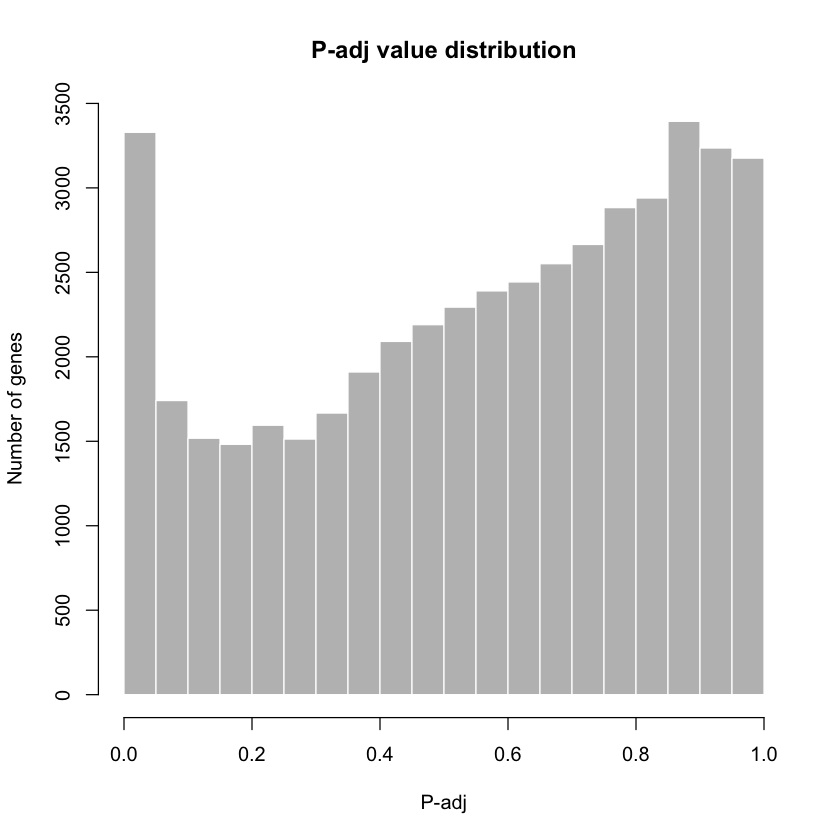

In [6]:
tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
  ylab = "Number of genes", main = "P-adj value distribution")

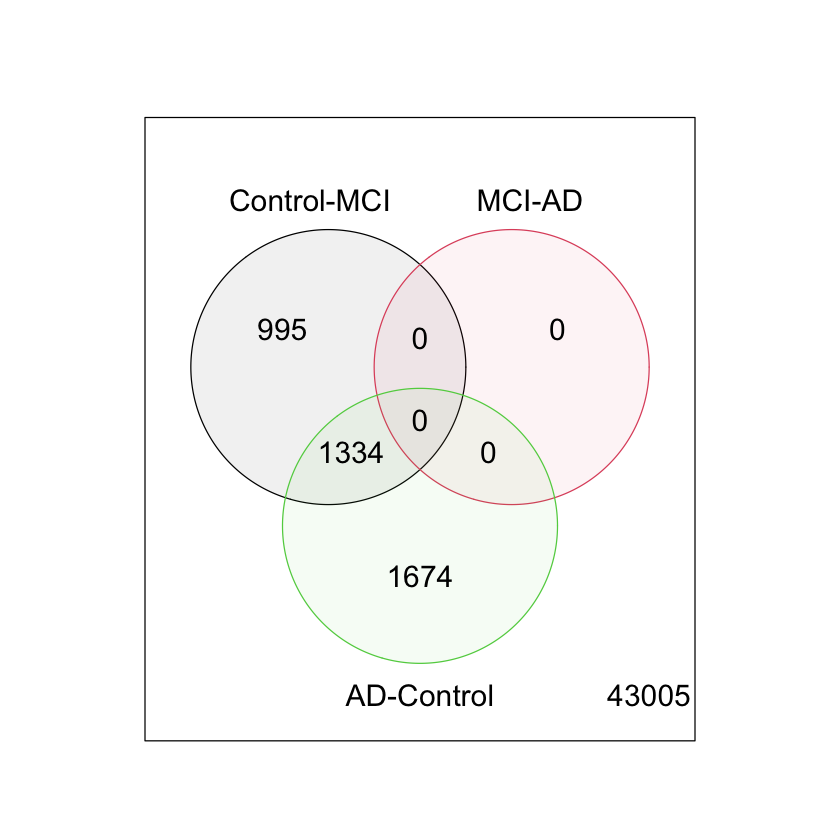

In [7]:
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05, lfc=0)
vennDiagram(dT, circle.col=palette()) # Genes that are upregulated/downregulated in both

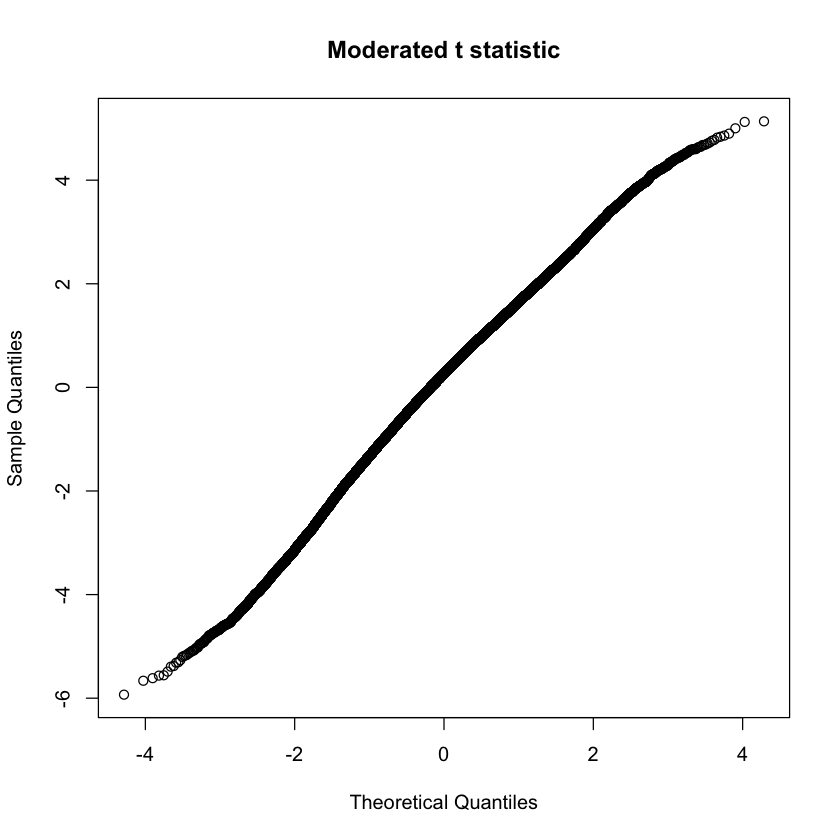

In [8]:
# create Q-Q plot for t-statistic
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

[1] "Control-MCI" "MCI-AD"      "AD-Control"

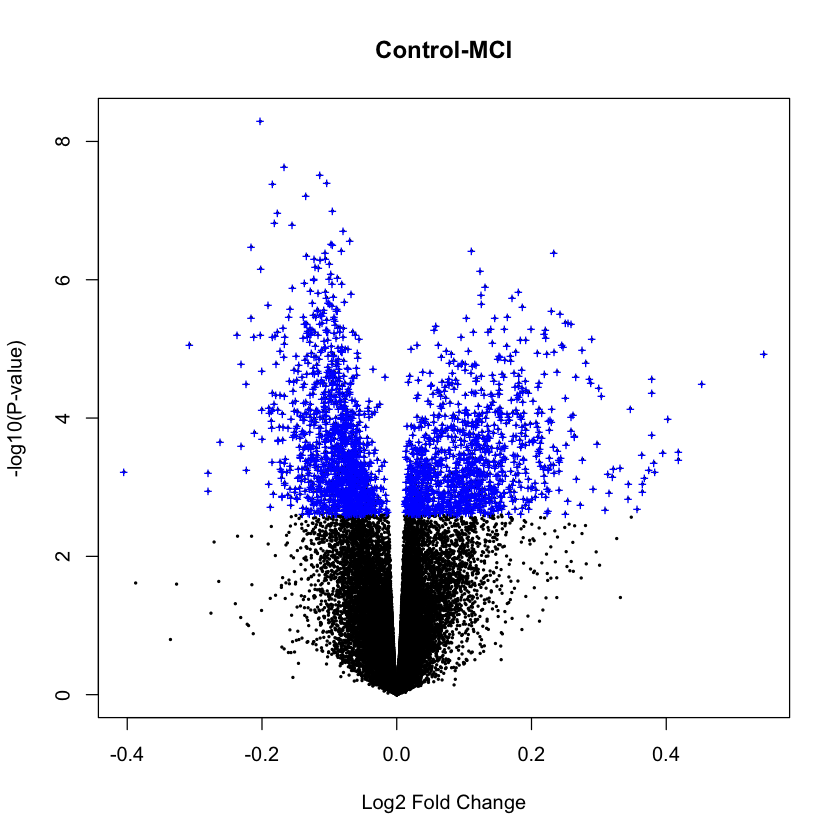

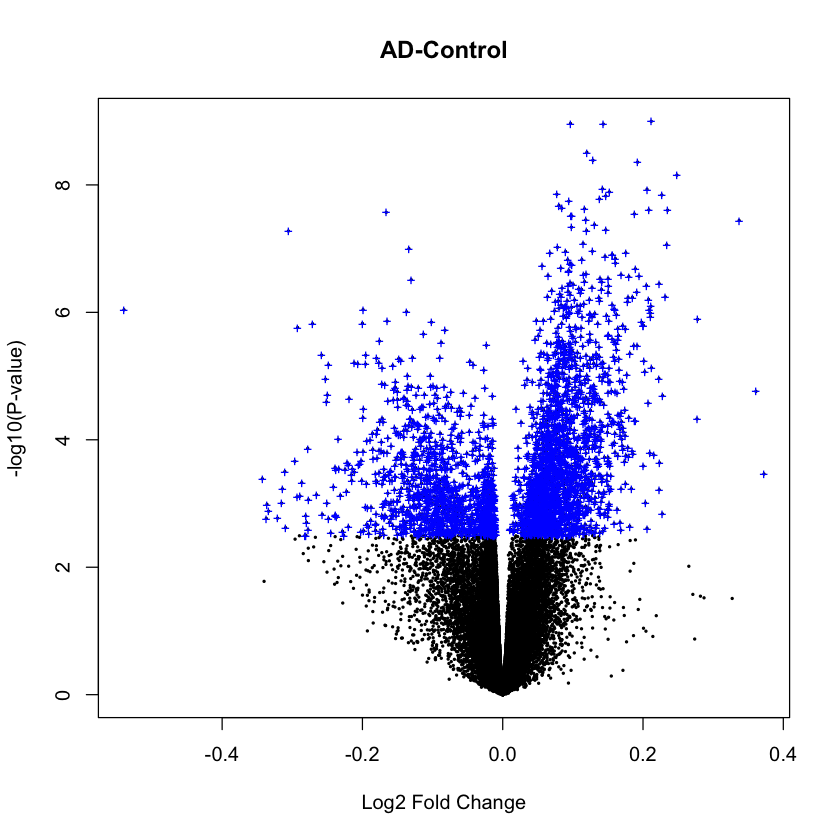

In [9]:
# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names


volcanoplot(fit2, coef=1, main=colnames(fit2)[1], pch=20,
  highlight=length(which(dT[,1]!=0)), names=rep('+', nrow(fit2)))

volcanoplot(fit2, coef=3, main=colnames(fit2)[3], pch=20,
  highlight=length(which(dT[,3]!=0)), names=rep('+', nrow(fit2)))

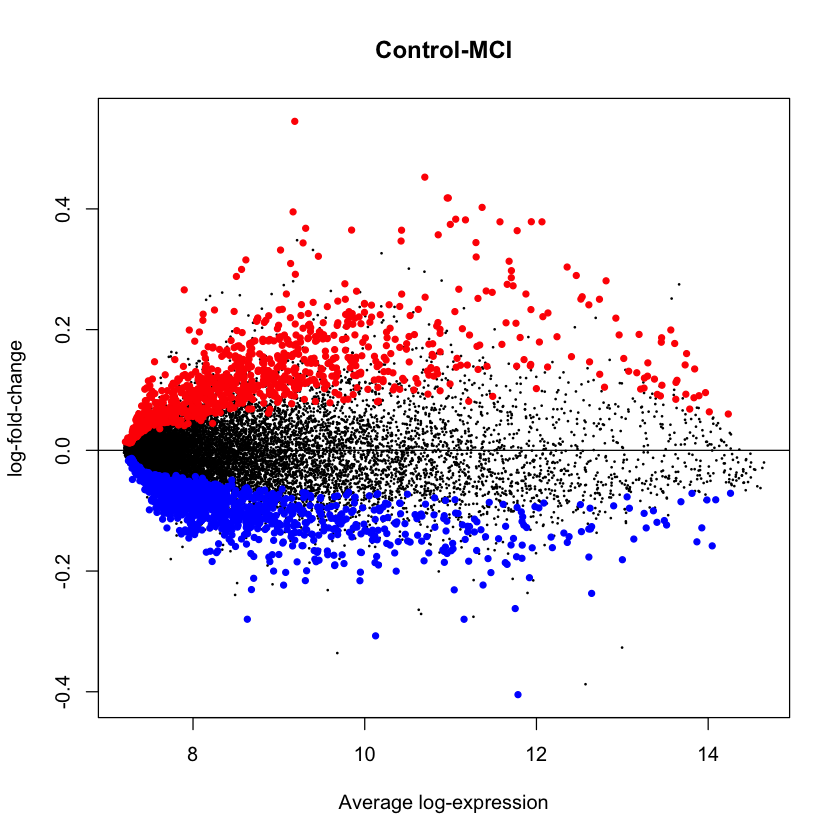

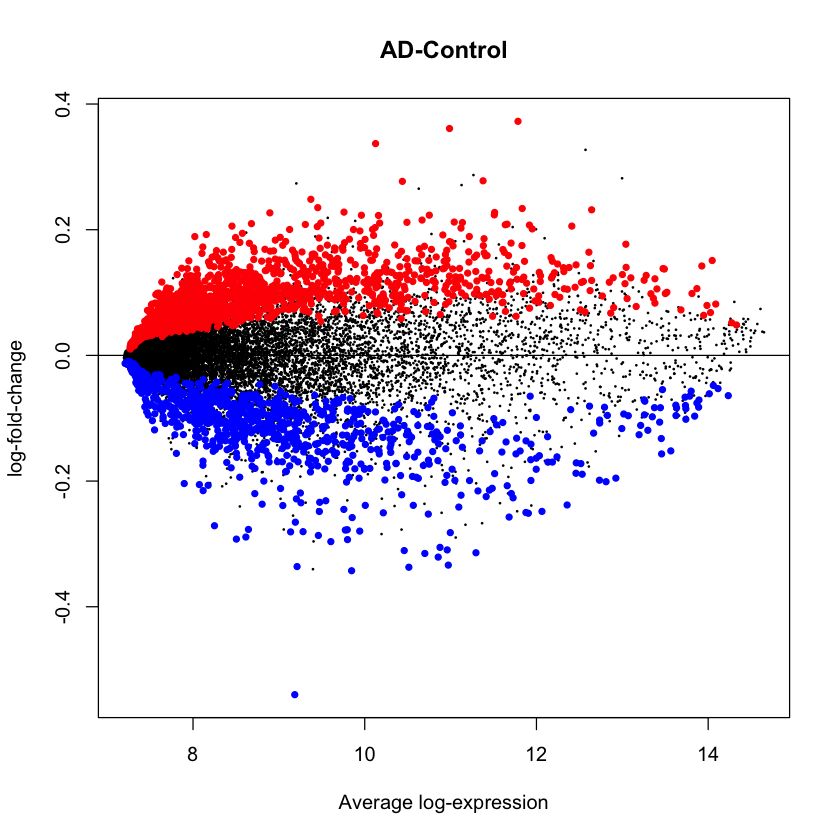

In [10]:
# MD plot (log fold change vs mean log expression)
plotMD(fit2, column=1, status=dT[,1], legend=F, pch=20, cex=1)
abline(h=0)

plotMD(fit2, column=3, status=dT[,3], legend=F, pch=20, cex=1)
abline(h=0)

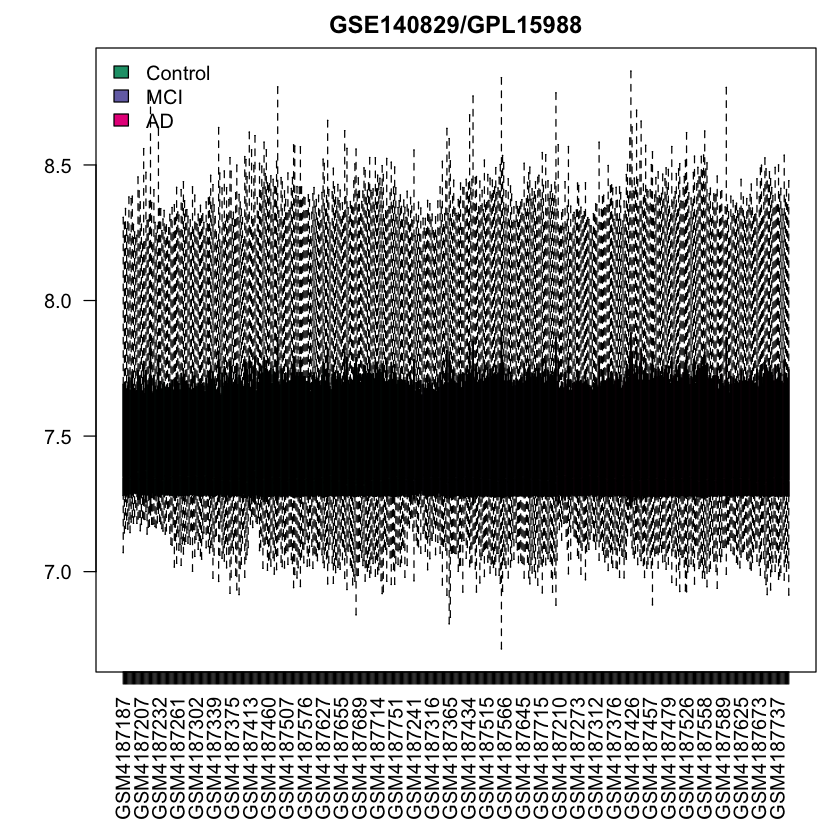

In [11]:
# box-and-whisker plot
ord <- order(gs)  # order samples by group
palette(c("#1B9E77", "#7570B3", "#E7298A", "#E6AB02", "#D95F02",
          "#66A61E", "#A6761D", "#B32424", "#B324B3", "#666666"))
par(mar=c(7,4,2,1))
title <- paste ("GSE140829", "/", annotation(gset), sep ="")
boxplot(ex[,ord], boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=gs[ord])
legend("topleft", groups, fill=palette(), bty="n")

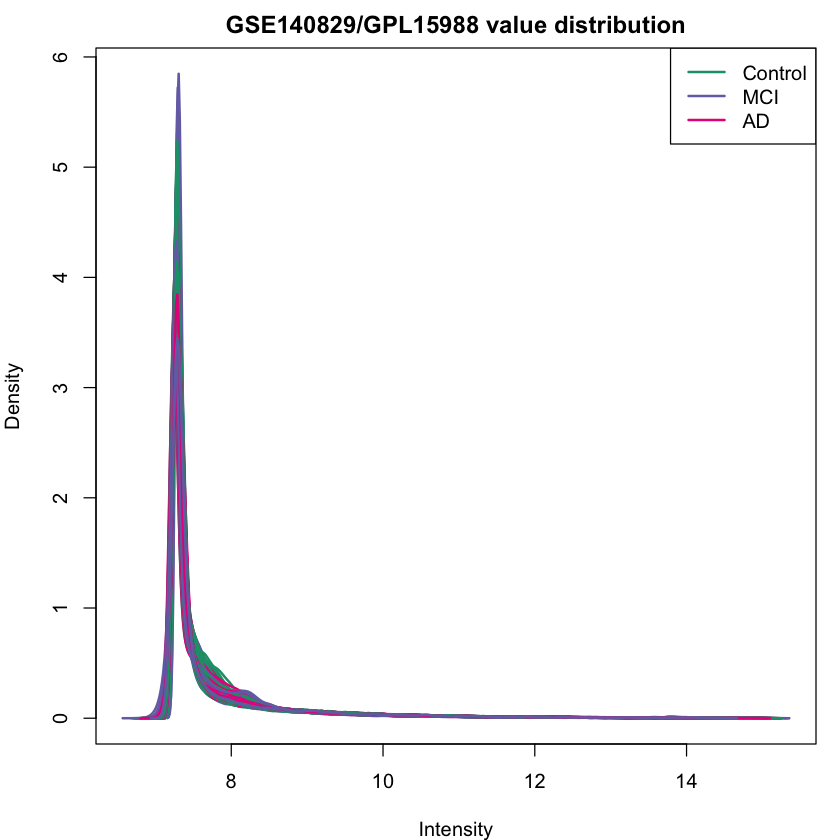

In [12]:
# expression value distribution
par(mar=c(4,4,2,1))
title <- paste ("GSE140829", "/", annotation(gset), " value distribution", sep ="")
plotDensities(ex, group=gs, main=title, legend ="topright")

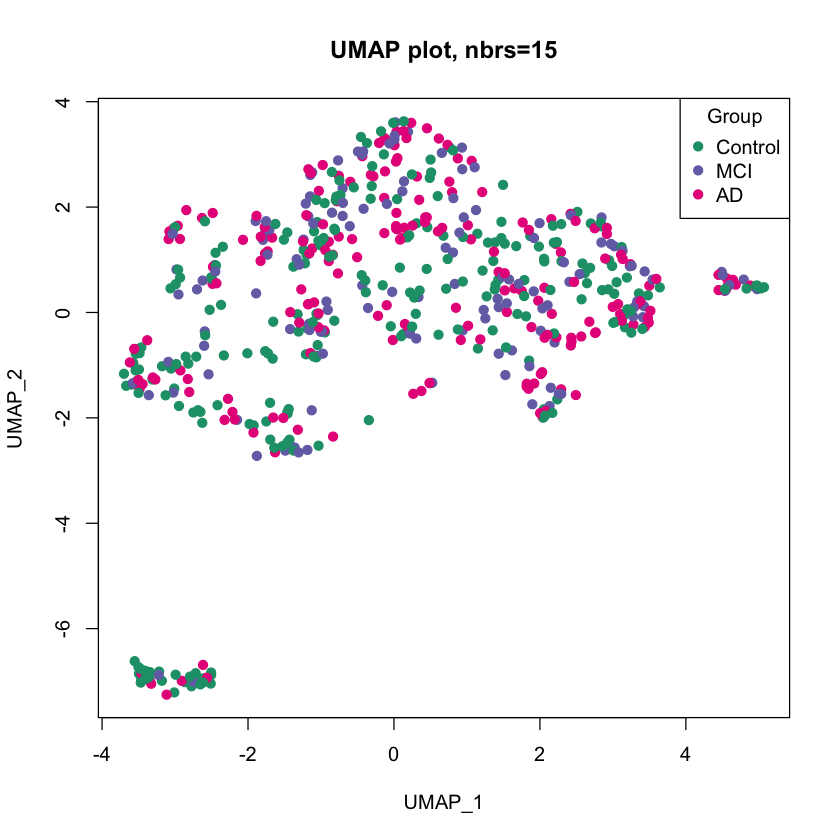

In [13]:
#UMAP plot
ex <- na.omit(ex) # eliminate rows with NAs
ex <- ex[!duplicated(ex), ]  # remove duplicates
ump <- umap(t(ex), n_neighbors = 15, random_state = 123)
plot(ump$layout, main="UMAP plot, nbrs=15", xlab="UMAP_1", ylab="UMAP_2", col=gs, pch=20, cex=1.5)
legend("topright", legend=levels(gs), pch=20, col=1:nlevels(gs), title="Group", pt.cex=1.5)


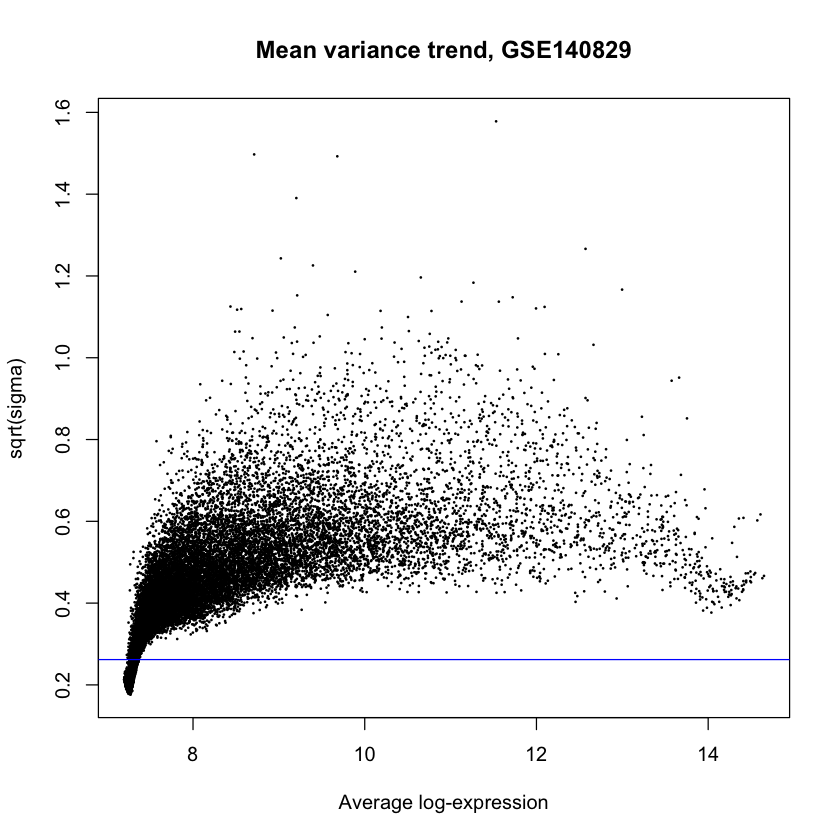

In [14]:
# mean-variance trend, helps to see if precision weights are needed
plotSA(fit2, main="Mean variance trend, GSE140829")

# KEGG and GSEA Analysis

In [15]:
BiocManager::install("clusterProfiler")
BiocManager::install("pathview")
BiocManager::install("enrichplot")
BiocManager::install("org.Hs.eg.db")
install.packages("dplyr")
install.packages("ggridges")
library(dplyr)
library(clusterProfiler)
library(enrichplot)
library(ggplot2)
library(ggridges)
library("org.Hs.eg.db", character.only = TRUE)
library(pathview)
library(ggridges)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.25), R 4.3.3 (2024-02-29)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'clusterProfiler'"
Old packages: 'RcppArmadillo', 'curl', 'dendextend', 'fontawesome', 'later',
  'progressr', 'promises', 'reticulate', 'uwot'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.25), R 4.3.3 (2024-02-29)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'pathview'"
Old packages: 'RcppArmadillo', 'curl', 'dendextend', 'f


The downloaded binary packages are in
	/var/folders/2r/2m1p3nmd3m1235kf7dxs1cl40000gn/T//RtmpzhkkDU/downloaded_packages

The downloaded binary packages are in
	/var/folders/2r/2m1p3nmd3m1235kf7dxs1cl40000gn/T//RtmpzhkkDU/downloaded_packages



Attaching package: 'dplyr'


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




clusterProfiler v4.10.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:stats':

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges

Loading required package: S4Vectors



# AD & Control

In [44]:
organism = "org.Hs.eg.db"
original_gene_list <- as.numeric(tT$AD.Control)
names(original_gene_list) <- tT$GENE.SYMBOL


gene_list <- na.omit(original_gene_list)
gene_list <- gene_list[!is.na(names(gene_list))]

gene_df <- data.frame(gene = names(gene_list), score = gene_list)
gene_list_agg <- aggregate(score ~ gene, data = gene_df, FUN = mean)
gene_list <- setNames(gene_list_agg$score, gene_list_agg$gene)
gene_list <- sort(gene_list, decreasing = TRUE)

gse <- gseGO(geneList=gene_list,
             ont ="ALL",
             keyType = "SYMBOL",
             minGSSize = 3,
             maxGSSize = 800,
             pvalueCutoff = 0.05,
             verbose = TRUE,
             OrgDb = organism,
             pAdjustMethod = "none")

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation."
leading edge analysis...

done...



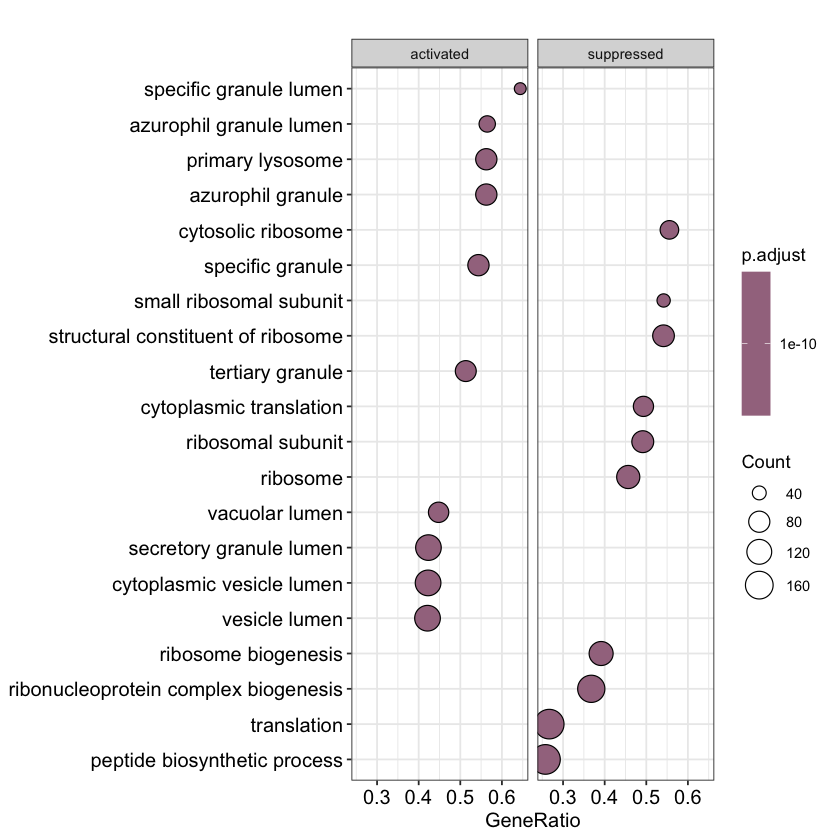

In [45]:
require(DOSE)
dotplot(gse, label_format = 50, showCategory=10, split=".sign") + facet_grid(.~.sign)

In [46]:
gse <- pairwise_termsim(gse)
emapplot(gse, showCategory = 10)

ERROR while rich displaying an object: Error in `geom_edge_link()`:
! Problem while converting geom to grob.
i Error occurred in the 1st layer.
Caused by error in `pathAttr()`:
! long vectors not supported yet: /Volumes/Builds/R4/R-4.3.3/src/include/Rinlinedfuns.h:537

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in re

In [47]:
cnetplot(gse, categorySize="pvalue", foldChange=gene_list, showCategory = 3)

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version."
ERROR while rich displaying an object: Error in `geom_edge()`:
! Problem while converting geom to grob.
i Error occurred in the 1st layer.
Caused by error:
! vector memory exhausted (limit reached?)

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. with

Picking joint bandwidth of 0.0157



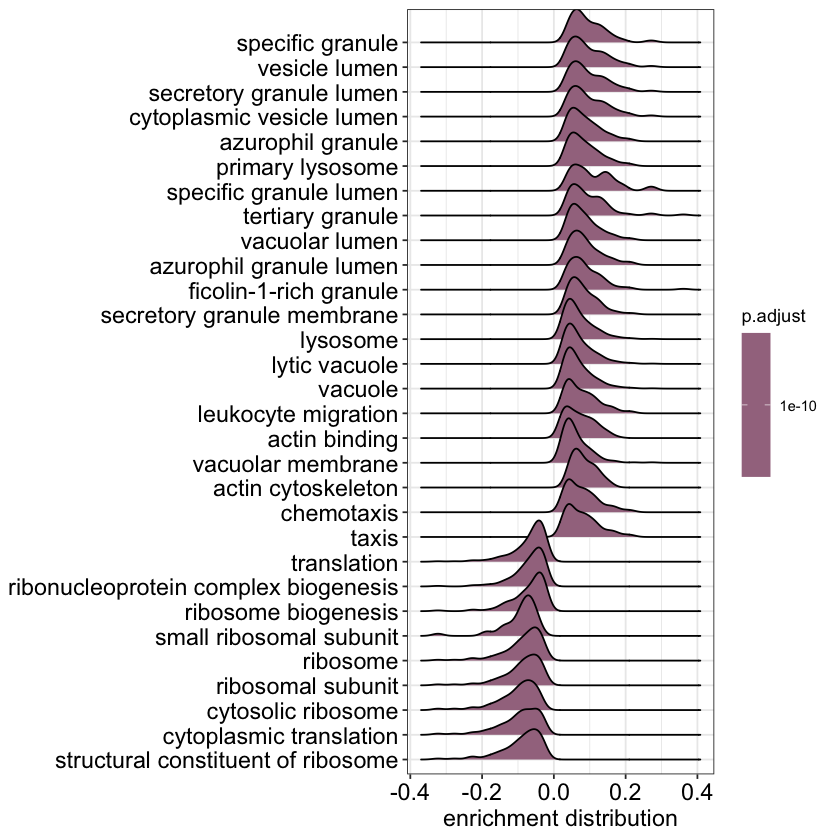

In [48]:
ridgeplot(gse, label_format = 50) + labs(x = "enrichment distribution")

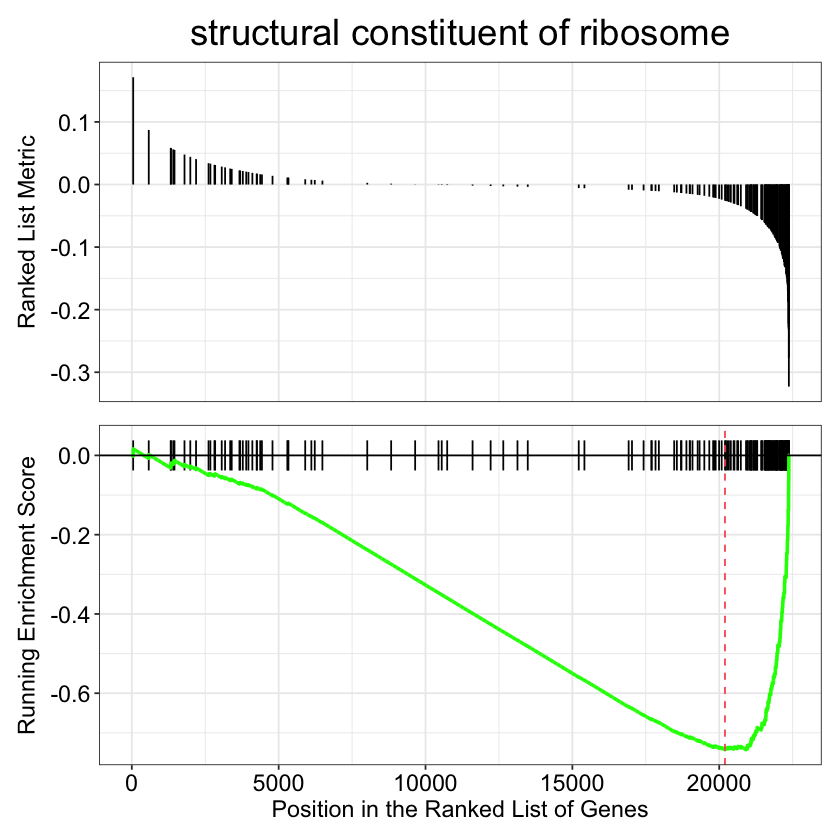

In [49]:
gseaplot(gse, by = "all", title = gse$Description[1], geneSetID = 1)

In [50]:
ids<-bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db")
dedup_ids = ids[!duplicated(ids[c("SYMBOL")]),]
tT_subset = tT[,c("GENE.SYMBOL", "AD.Control", "F", "P.Value", "adj.P.Val")]
combined_set <- merge(dedup_ids, tT_subset, by.x = "SYMBOL", by.y = "GENE.SYMBOL", all.x = TRUE)
clean_combined_set <- combined_set[!duplicated(combined_set), ]

clean_combined_set <- clean_combined_set %>%
  group_by(SYMBOL, ENTREZID) %>%
  summarize(
    AD.Control = mean(AD.Control, na.rm = TRUE),
    F = mean(F, na.rm = TRUE),
    P.Value = mean(P.Value, na.rm = TRUE),
    adj.P.Val = mean(adj.P.Val, na.rm = TRUE),
    .groups = "drop"  # Optional: to remove the grouping after summarizing
  )

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENTREZID", :
"20.04% of input gene IDs are fail to map..."


In [51]:
kegg_gene_list <- clean_combined_set$AD.Control
names(kegg_gene_list) <- clean_combined_set$ENTREZID
kegg_gene_list <- na.omit(kegg_gene_list)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

kegg_organism = "hsa"
kk2 <- gseKEGG(geneList     = kegg_gene_list,
               organism     = kegg_organism,
               nPerm        = 10000,
               minGSSize    = 3,
               maxGSSize    = 800,
               pvalueCutoff = 0.05,
               pAdjustMethod = "none",
               keyType       = "ncbi-geneid")

preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
"We do not recommend using nPerm parameter incurrent and future releases"
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
"You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call."
leading edge analysis...

done...



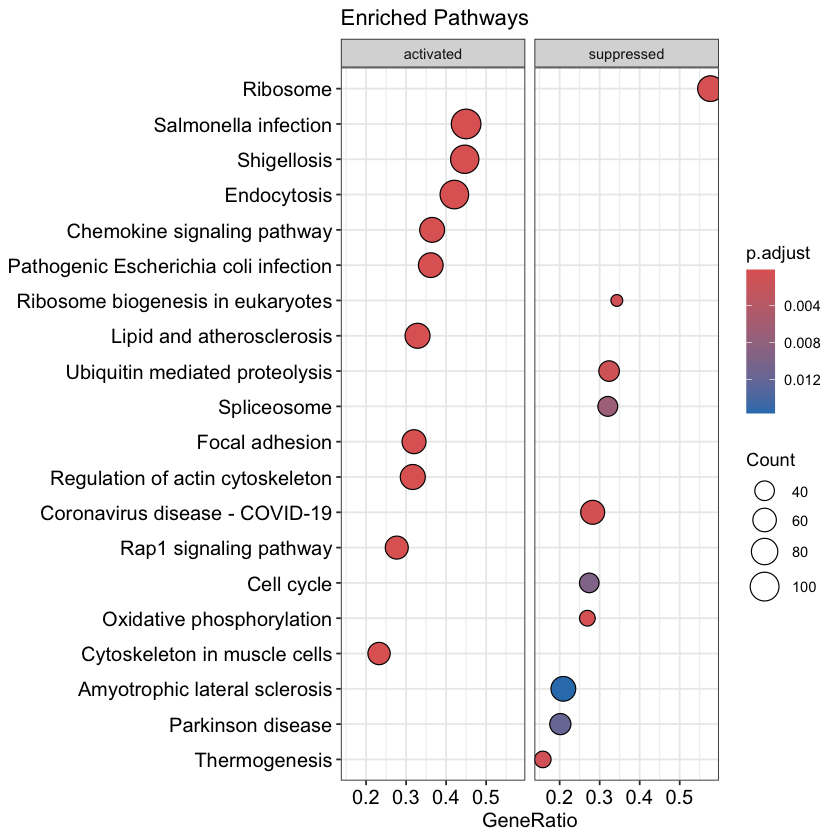

In [52]:
dotplot(kk2, label_format = 50, showCategory = 10, title = "Enriched Pathways" , split=".sign") + facet_grid(.~.sign)

Picking joint bandwidth of 0.015



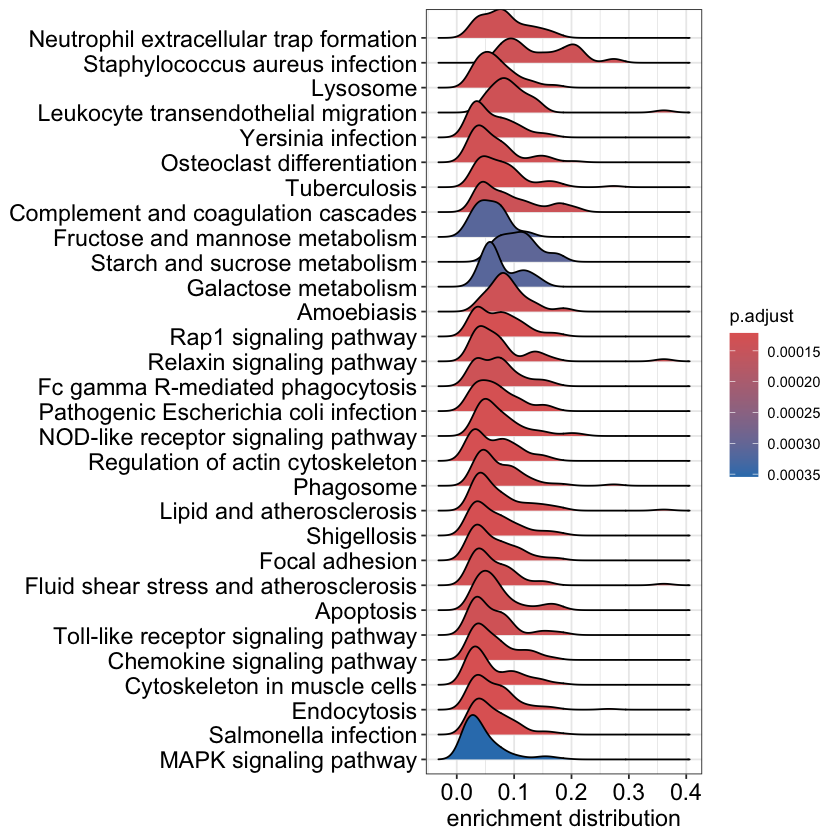

In [55]:
ridgeplot(kk2, label_format = 50) + labs(x = "enrichment distribution")

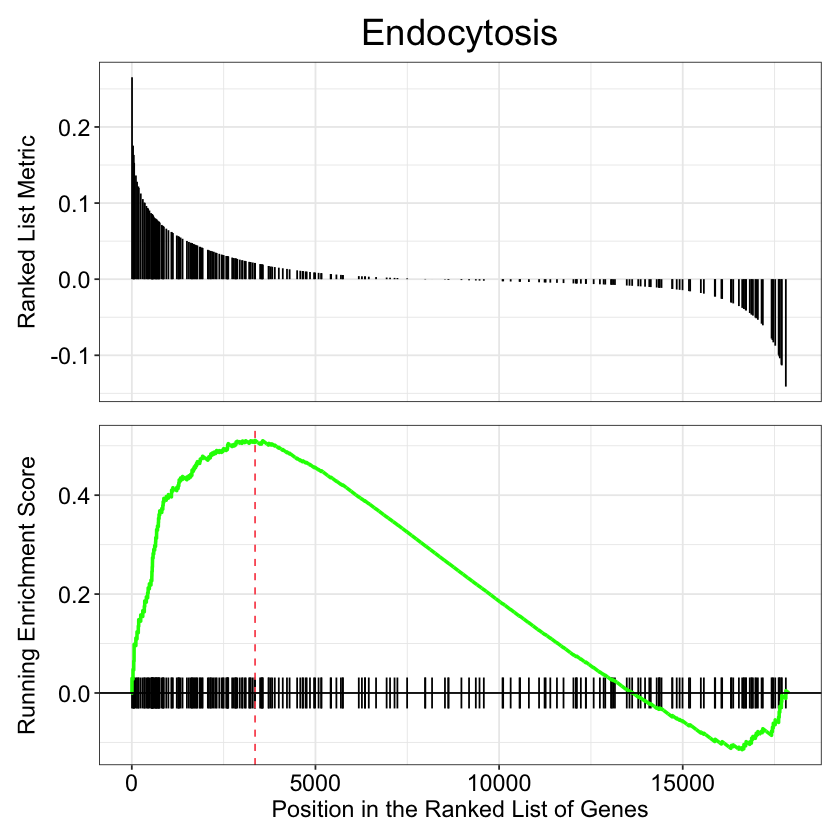

In [58]:
gseaplot(kk2, by = "all", title = kk2$Description[2], geneSetID = 2)

In [29]:
#dme <- pathview(gene.data=kegg_gene_list, pathway.id="dme04130", species = kegg_organism)

# MCI & Control

In [30]:
organism = "org.Hs.eg.db"
original_gene_list <- as.numeric(tT$Control.MCI)
names(original_gene_list) <- tT$GENE.SYMBOL


gene_list <- na.omit(original_gene_list)
gene_list <- gene_list[!is.na(names(gene_list))]

gene_df <- data.frame(gene = names(gene_list), score = gene_list)
gene_list_agg <- aggregate(score ~ gene, data = gene_df, FUN = mean)
gene_list <- setNames(gene_list_agg$score, gene_list_agg$gene)
gene_list <- sort(gene_list, decreasing = TRUE)

gse <- gseGO(geneList=gene_list,
             ont ="ALL",
             keyType = "SYMBOL",
             minGSSize = 3,
             maxGSSize = 800,
             pvalueCutoff = 0.05,
             verbose = TRUE,
             OrgDb = organism,
             pAdjustMethod = "none")

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation."
leading edge analysis...

done...



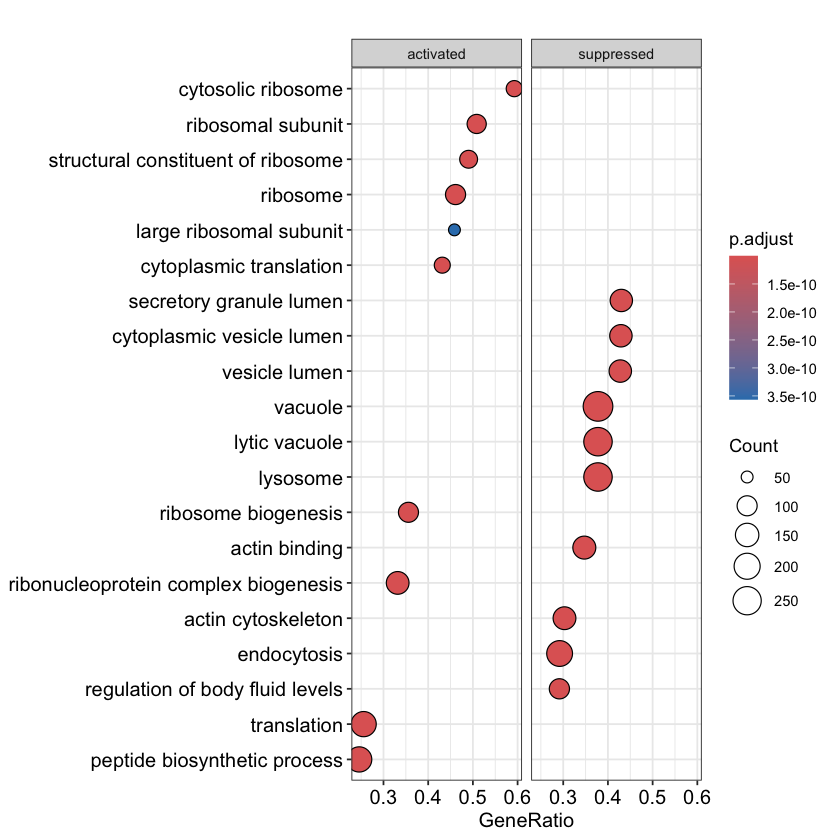

In [31]:
require(DOSE)
dotplot(gse, showCategory=10, label_format = 50, split=".sign") + facet_grid(.~.sign)

In [32]:
#gse <- pairwise_termsim(gse)
#emapplot(gse, showCategory = 10)

In [33]:
#cnetplot(gse, categorySize="pvalue", foldChange=gene_list, showCategory = 3)

Picking joint bandwidth of 0.0152



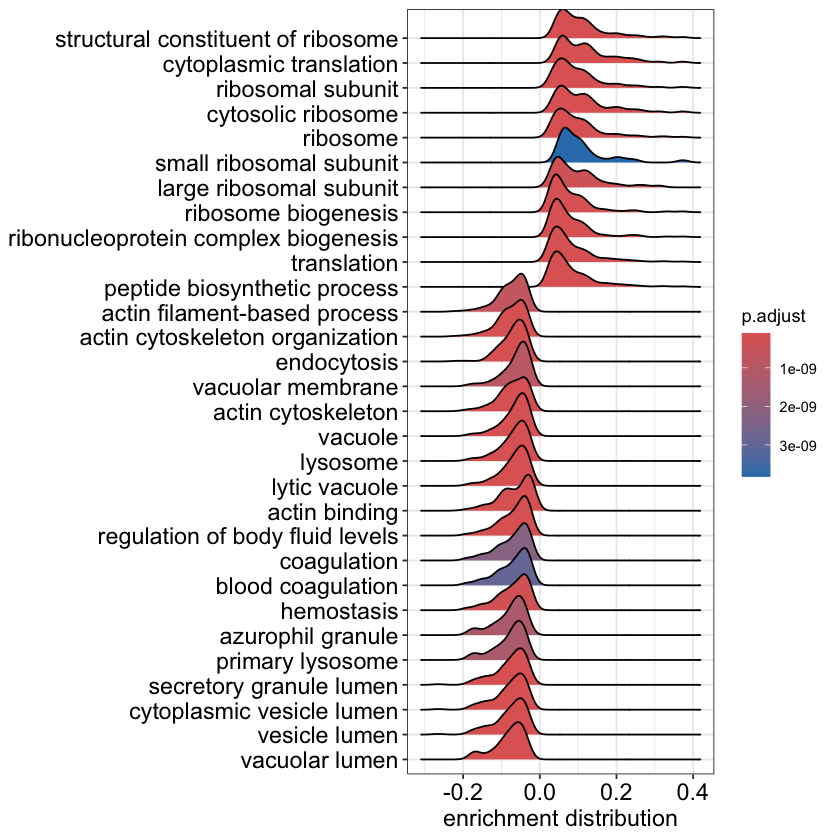

In [34]:
ridgeplot(gse, label_format = 50) + labs(x = "enrichment distribution")

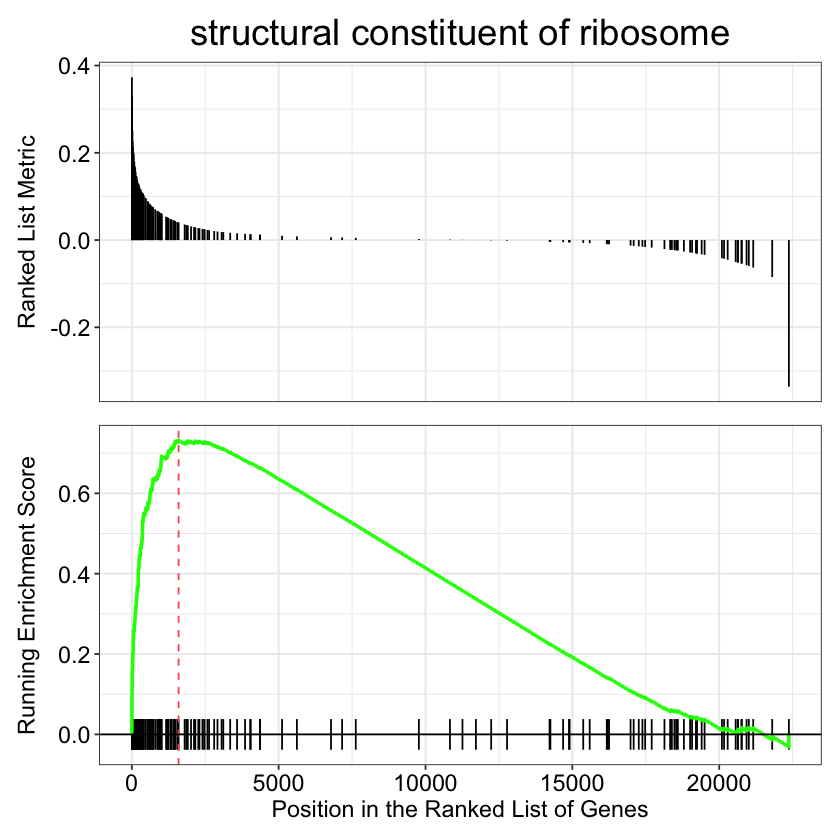

In [35]:
gseaplot(gse, by = "all", title = gse$Description[1], geneSetID = 1)

In [36]:
ids<-bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db")
dedup_ids = ids[!duplicated(ids[c("SYMBOL")]),]
tT_subset = tT[,c("GENE.SYMBOL", "AD.Control", "F", "P.Value", "adj.P.Val")]
combined_set <- merge(dedup_ids, tT_subset, by.x = "SYMBOL", by.y = "GENE.SYMBOL", all.x = TRUE)
clean_combined_set <- combined_set[!duplicated(combined_set), ]

clean_combined_set <- clean_combined_set %>%
  group_by(SYMBOL, ENTREZID) %>%
  summarize(
    AD.Control = mean(AD.Control, na.rm = TRUE),
    F = mean(F, na.rm = TRUE),
    P.Value = mean(P.Value, na.rm = TRUE),
    adj.P.Val = mean(adj.P.Val, na.rm = TRUE),
    .groups = "drop"  # Optional: to remove the grouping after summarizing
  )

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENTREZID", :
"20.04% of input gene IDs are fail to map..."


In [37]:
kegg_gene_list <- clean_combined_set$AD.Control
names(kegg_gene_list) <- clean_combined_set$ENTREZID
kegg_gene_list <- na.omit(kegg_gene_list)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

kegg_organism = "hsa"
kk2 <- gseKEGG(geneList     = kegg_gene_list,
               organism     = kegg_organism,
               nPerm        = 10000,
               minGSSize    = 3,
               maxGSSize    = 800,
               pvalueCutoff = 0.05,
               pAdjustMethod = "none",
               keyType       = "ncbi-geneid")

preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
"We do not recommend using nPerm parameter incurrent and future releases"
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
"You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call."
leading edge analysis...

done...



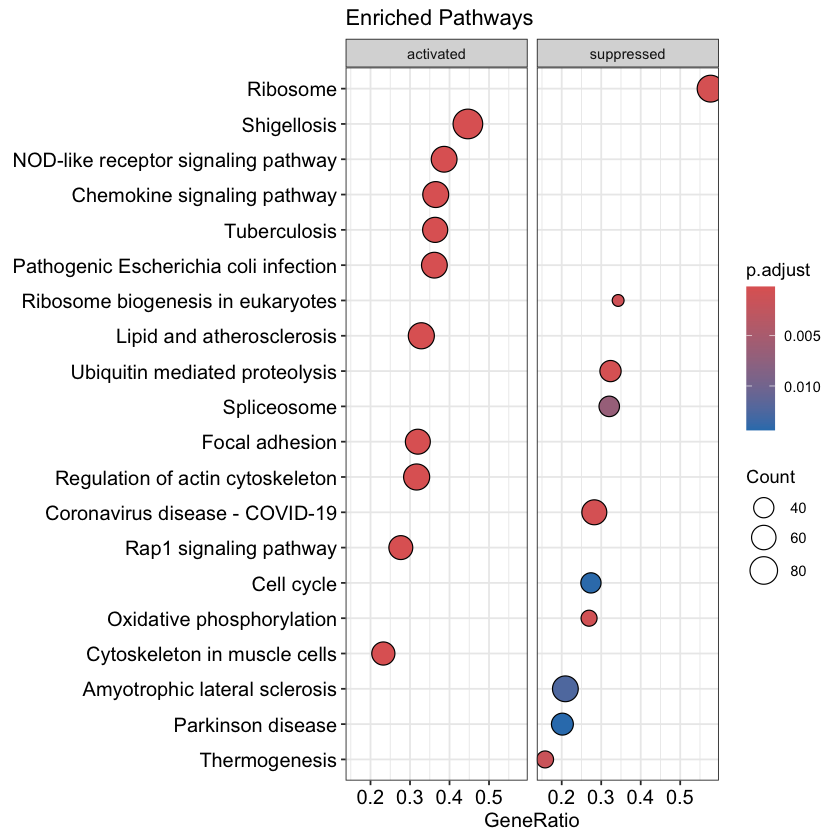

In [38]:
dotplot(kk2, showCategory = 10, label_format = 50, title = "Enriched Pathways" , split=".sign") + facet_grid(.~.sign)

In [39]:
#kk2 <- pairwise_termsim(kk2)
#emapplot(kk2)

In [40]:
#cnetplot(kk2, categorySize="pvalue", foldChange=gene_list)

Picking joint bandwidth of 0.0154



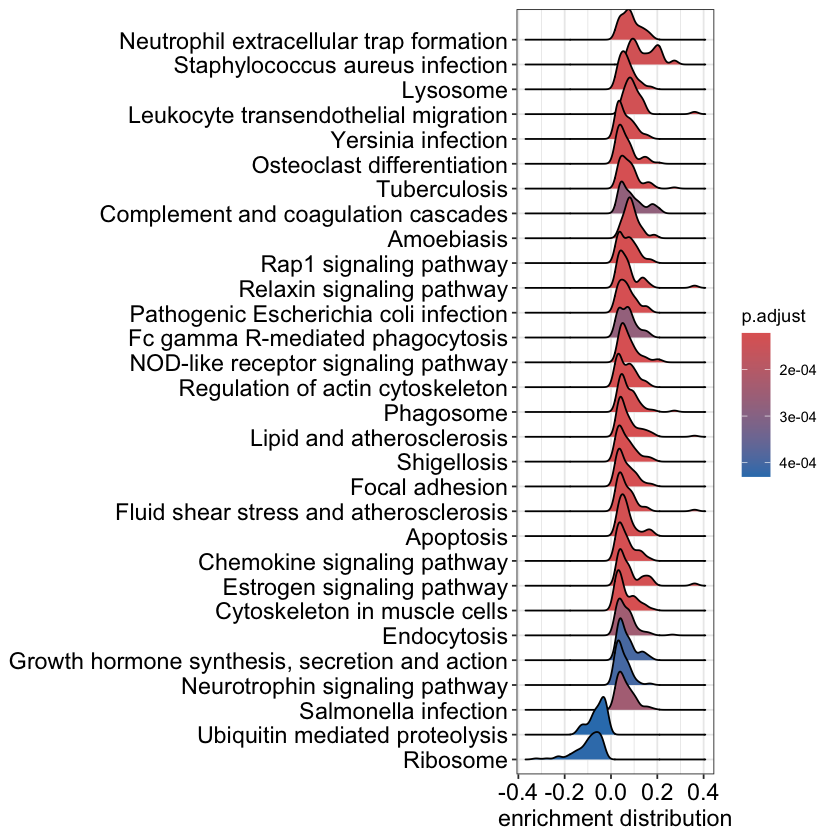

In [41]:
ridgeplot(kk2, label_format = 50) + labs(x = "enrichment distribution")

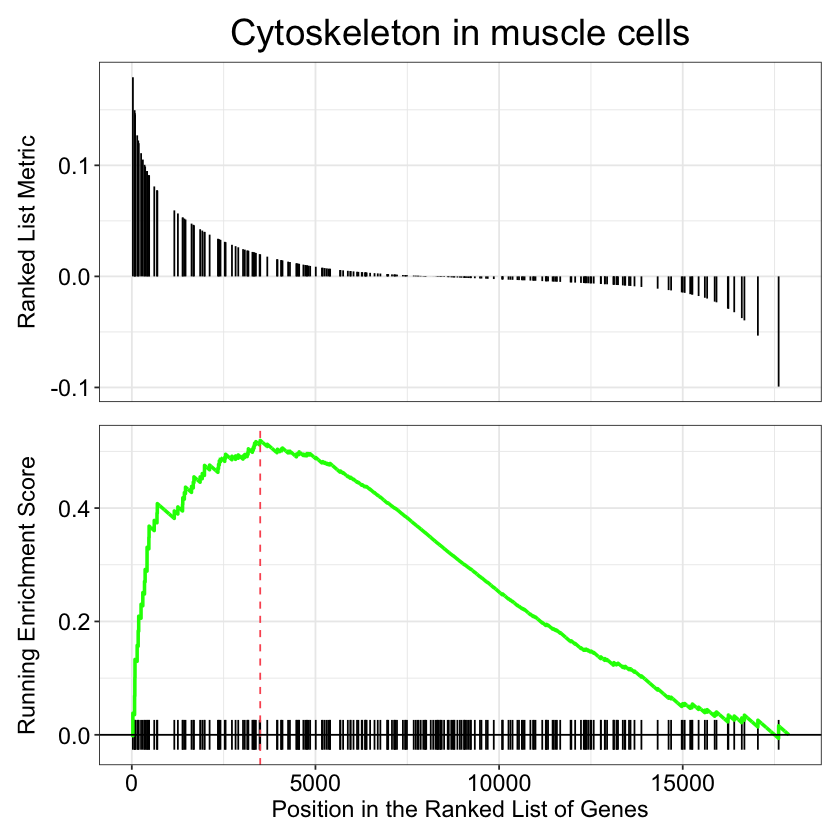

In [42]:
gseaplot(kk2, by = "all", title = kk2$Description[1], geneSetID = 1)

In [43]:
#dme <- pathview(gene.data=kegg_gene_list, pathway.id="dme04130", species = kegg_organism)